# Finding causal genotype-phenotype relations with ddlite: learning

## Introduction
In this example **ddlite** app, we'll build a system to indentify causal relationships between genotypes and phenotypes from raw journal articles. For the extraction stage, see **GenePhenRelationExample_Extraction.ipynb**.

In [1]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

## Loading candidate extractions
First, we'll load in the pickled candidates that we created in the last notebook. We can construct a `Relations` object with the file. We'll extract features and pickle them to save time in the future.

In [2]:
pkl_feats = 'gene_phen_relation_example/gene_phen_saved_feats_v2.pkl'
pkl_rel = 'gene_phen_relation_example/gene_phen_saved_relations_v2.pkl'
try:
    with open(pkl_feats, 'rb') as f:
        R = cPickle.load(f)
except:
    R = Relations(pkl_rel)
    %time R.extract_features()
    with open(pkl_feats, 'w+') as f:
        cPickle.dump(R, f)

## `CandidateModel` objects and feature generation
We'll then create a `CandidateModel` object for our extracted gene candidates. Features are automatically generated by `Relations`.

In [3]:
CM = CandidateModel(R)
print "Extracted {} features for each of {} mentions".format(CM.num_feats(), CM.num_candidates())

Extracted 89097 features for each of 4185 mentions


In [4]:
print "Feature sparsity: {:.5f}".format(float(CM.feats.nnz) / np.product(CM.feats.shape))

Feature sparsity: 0.00090


## Building a ground truth set
We'll load some "gold standard" labels which were generated from a previous MindTagger session. 

In [5]:
with open('gene_phen_relation_example/medium_simple_holdout.pkl', 'rb') as f:
    CM.set_gold_labels(cPickle.load(f))
CM.set_holdout()

## Writing labeling functions
We'll use the **data programming method** to learn a logistic regression model which will predict the probability of a candidate entity being a true causal relationship. We'll start by writing labeling functions, or LFs. These are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example).

In [6]:
from GenePhenLFs import lfs

In [7]:
CM.apply_lfs(lfs, clear=True)

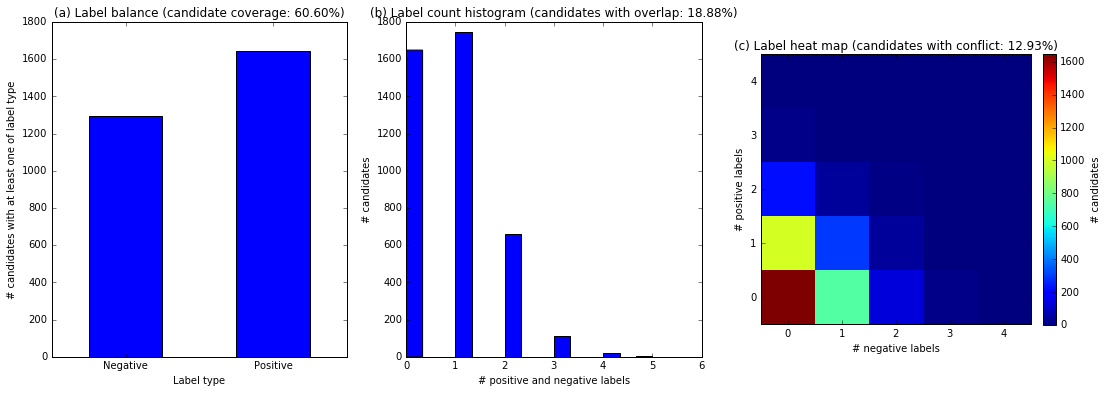

In [8]:
CM.plot_lf_stats()

In [9]:
CM.top_conflict_lfs(n=5)

Labeling function,Fraction of candidates where LF has conflict
lf_long,0.047
lf_mutation,0.043
lf_p_1,0.029
lf_all,0.019
lf_p_3,0.019


In [10]:
CM.lowest_coverage_lfs(n=5)

Labeling function,Fraction of abstained votes
lf_p_4,1.000
lf_p_8,0.999
lf_p_7,0.999
lf_express,0.997
lf_loss,0.997


In [12]:
CM.lowest_empirical_accuracy_lfs(n=20)

Labeling function,Empirical LF accuracy
lf_p_4,0.000 (n=0)
lf_aut,0.556 (n=9)
lf_long,0.558 (n=43)
lf_p_5,0.600 (n=10)
lf_p_1,0.661 (n=124)
lf_p_3,0.721 (n=68)
lf_short,0.733 (n=15)
lf_mutation,0.746 (n=71)
lf_p_2,0.750 (n=12)
lf_loss,1.000 (n=1)


## Learning

Running test fold 0


../ddlite.py:1005: UserWarning: SGD did not converge for mu=0.001. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Running test fold 1
Running test fold 2


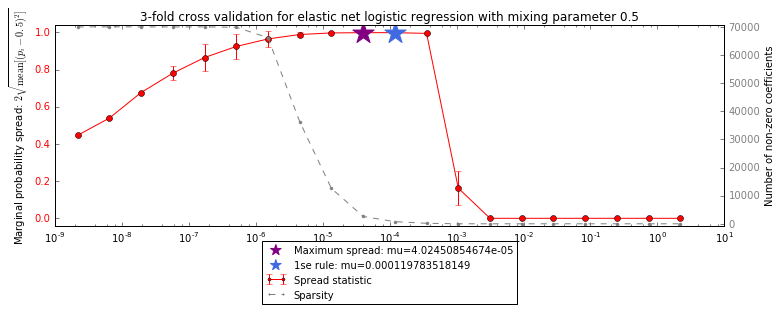

CPU times: user 22min 16s, sys: 600 ms, total: 22min 17s
Wall time: 22min 42s


<ddlite.ModelLog instance at 0x7f56edda9998>

In [19]:
matplotlib.rcParams['figure.figsize'] = (12,4)
%time CM.learn_weights(tol=1e-3, sample=True, maxIter=2500, n_mu=20, mu_min_ratio=1e-9, alpha=0.5, opt_1se=True, verbose=True, plot=True, log=True)

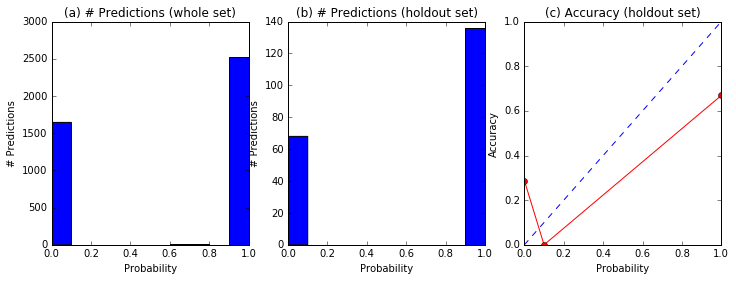

In [20]:
CM.plot_calibration()

In [21]:
print "Number of non-zero weights: {}".format(np.sum(np.abs(CM.w) > 1e-12))

Number of non-zero weights: 761


In [22]:
np.sum(CM._gold_labels == -1)

64

In [23]:
np.sum(CM._gold_labels == 1)

140

In [24]:
yy = CM.get_predicted('holdout')
yz = CM._gold_labels[CM.holdout]

In [25]:
yy * yz

array([-1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
        1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,
       -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
        1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,
        1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,
        1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1

In [26]:
np.mean(yy*yz == 1)

0.53921568627450978

In [27]:
np.sum(yy == -1)

68

In [28]:
np.sum(yz == -1)

64

In [29]:
CM.w[:50]

array([  5.39033503e-01,   6.66246903e-01,   6.36343475e-01,
         5.22162144e-01,   1.81975686e+00,   7.31707187e-01,
        -9.37310833e-06,   5.96260511e-01,   4.86813617e-01,
         5.84935174e-01,   6.03248746e-01,   7.20265289e-01,
         5.41470579e-01,   5.95010729e-01,  -0.00000000e+00,
         1.18125352e+00,   5.86704600e-01,   6.07096932e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,

In [36]:
np.sum(np.abs(CM.w) > 5)

0